# Pyfar Introduction

The **Py**thon packages **f**or **A**coustics **R**esearch (pyfar) aim at providing methods and functionality for acoustics research in a unified and comprehensive framework.
Pyfar is developed with a strong focus on:

- **Online documentation**.
- **Automated testing**.
- Unrestricted use through the liberal MIT or CC-BY **open source** licenses.

The **pyfar base package** contains classes and functions for the acquisition, inspection, and processing of audio signals.
For ease of maintainability and robustness to future changes, applied or specific features are split into sub-packages which extend the base package. These currently include:

- **sofar**: SOFA file reader and writer functionality.
- **spharpy**: Spherical array signal processing.
- **pyrato**: Tools for room acoustic analysis.

Please refer to [pyfar.org](https://pyfar.org) for an up-to-date list of packages and their intended use cases.

We develop all packages openly across diverse research institutions, avoiding general branding of code or functionality. Contributions (in any form, i.e. reporting issues, submitting bug-fixes or implementation of new features) are welcome. 
To get in touch, either contact us via

- [GitHub](https://github.com/pyfar).
- [Join the Slack channel](https://join.slack.com/t/pyfar/shared_invite/zt-2eacdhww2-iUiPnh_wuqg2zD939wL4kw).
- Write an old-school e-mail to info@pyfar.org.

## Example Gallery

This notebook, among others, is part of [pyfar's example gallery](https://pyfar-gallery.readthedocs.io/en/latest/).
The gallery contains:

- Notebooks supplementary to the [documentation](https://pyfar.readthedocs.io/en/stable).
- Application examples giving an overview over the use cases pyfar and its sub-packages.

All examples can either be 

- viewed as statically rendered web-pages,
- interactively executed on mybinder.org,
- downloaded and run locally.

The respective links are located at the top of each example notebook. 

To follow along with the workshop document, either navigate to [pyfar.org](https://pyfar.org) and scroll down to the **Workshops** section and select the **pyfar introduction**, or scan the following QR code:

<img src="../../resources/qr-code-pyfar-intro-jupyter.svg" alt="QR Code" width="400"/>

### _Disclaimer_:
Please note that this is not a Python tutorial. We assume that you are aware of basic Python coding and concepts. For installations or set-up instructions please refer to the [getting started section of the documentation](https://pyfar.readthedocs.io/en/stable/readme.html#getting-started).

In [ ]:
# import packages
import pyfar as pf
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Audio

# set matplotlib backend for plotting
%matplotlib ipympl

# Example: Measurement Based Equalization Filter

In the following, the creation of a measurement based equalization filter is used as an example of showing pyfar's functionality, namely

- [Audio data and signals](#audio-data)
- [Plotting](#interactive-plotting)
- [Import and export](#import/export)
- [Digital signal processing functions](#digital-signal-processing)
- [Filter classes](#filter-classes)

Subsequently, the example of a [head-related impulse response](#example:-hrtf) will briefly introduce

- [Coordinates](#coordinates)
- [2D Plots](#2d-plots)

## Audio Data

Audio data are the basis of pyfar and most data will be stored as `Signal` objects. Signals are intended for equally sampled time and frequency data. Examples for this are audio recordings and impulse responses, or corresponding spectra. Similarly, `TimeData` and `FrequencyData` objects are intended to store incomplete audio data, such as (third)-octave data or results from numerical simulations. A more detailed introduction to pyfar audio objects can be found [here](https://pyfar-gallery.readthedocs.io/en/latest/gallery/interactive/pyfar_audio_objects.html). 

Signals can be created in different ways.
One possibility is to use the [pyfar.signals](https://pyfar.readthedocs.io/en/stable/modules/pyfar.signals.html) module. It contains functions for creating common signals like impulses, pure tone sine signals, swept sinusoids, and noise. Let's create an impulse with a length of 32 samples.

In [ ]:
impulse = pf.signals.impulse(32, delay=2)

The underlying time and frequency data of the `Signal` object are stored as numpy arrays. We can access the time data with the `time` attribute.

In [ ]:
impulse.time

Accessing the frequency data with the `freq` attribute will automatically compute the spectrum using the Fast Fourier Transform.

In [ ]:
impulse.freq

## Interactive Plotting

Let's have a look at the time signal and spectrum by using the [pyfar.plot](https://pyfar.readthedocs.io/en/stable/modules/pyfar.plot.html) module. The plot functions are based on matplotlib, but adjusted for a convenient use in acoustics (e.g., logarithmic frequency axis, magnitudes in dB...). Also, pyfar provides convenient **interactive keyboard shortcuts**. These allow switching plots, zooming in and out, moving along the x and y-axis, and zooming and moving the range of colormaps

To do this, you need to use an interactive matplotlib backend. For jupyter notebooks one can for example use the matplotlib magic `%matplotlib ipympl`, which has been executed at the top of the notebook already.

A list of available shortcuts is found in the [documentation](https://pyfar.readthedocs.io/en/stable/modules/pyfar.plot.html#pyfar.plot.shortcuts) or by executing the following function.


**All following figures can be used as interactive examples.** When the plot does not respond to the shortcuts, try clicking the figure to activate these for the figure.

In [ ]:
plt.figure()
pf.plot.time(impulse, unit='ms')
plt.show()

## Import/Export

Signals are often stored on disk. The [pyfar.io](https://pyfar.readthedocs.io/en/stable/modules/pyfar.io.html) module can read and write common audio file types such as *wav* and *mp3*. In addition, it can also import *sofa* files and data simulated with Comsol Multiphysics, and it allows saving and reading the workspace data including pyfar objects.

This is how to load the room impulse response (RIR) from a wav-file, we will use for creating an equalization filter in the following.

In [ ]:
rir = pf.io.read_audio(os.path.join(
    '..', '..', 'resources', 'impulse_response_measurement.wav'))

In [ ]:
plt.figure()
ax = pf.plot.time(rir)
plt.show()

## Digital Signal Processing


The [pyfar.signals.files](https://pyfar.readthedocs.io/en/stable/modules/pyfar.signals.files.html) module provides signals such as speech, castanets, drums, and guitar snippets, e.g., to have more natural signals for a quick demo of an audio system. Here, we choose a short anechoic guitar sample to simulate playback at the measured listener position by **convolving** it with the RIR. Because the sampling rates of the guitar sample and RIR do not match, the guitar signal is **resampled** first. 

In [ ]:
guitar = pf.signals.files.guitar()
guitar = pf.dsp.resample(guitar, rir.sampling_rate)
reverberant_guitar = pf.dsp.convolve(guitar, rir)

The reverberant signal can also be listened to using the jupyter Audio widget.

In [ ]:
Audio(reverberant_guitar.time, rate=guitar.sampling_rate)


Typically, it is not feasible to equalize for the exact frequency response a room, as notches and peaks are sensitive to local variations of the receiver position.
A more sensible approach is using a **smoothed magnitude spectrum** for room equalization.

In [ ]:
# 3rd octave smoothing of the RIR
rir_smoothed = pf.dsp.smooth_fractional_octave(rir, 3)[0]

# inspect original and smoothed RTF
plt.figure()
ax = pf.plot.freq(rir, dB=True, label='Original RTF', color='grey')
pf.plot.freq(rir_smoothed, dB=True, label='Smoothed RTF')
ax.legend()
plt.show()

The FIR equalization filter can be generated from the inverse magnitude spectrum in a straight forward manner. Due to the roll-off below 80 Hz, and above about 18 kHz, regularization outside these limits is required to avoid excessive noise amplification. These frequency limits are passed to the **inversion function**. Outside the desired frequency range, a regularization value is chosen such that the resulting spectrum does not show roll-offs, steep slopes, ringing or a long filter decay.

In [ ]:
frequency_range = [100, 18e3]
rir_inv = pf.dsp.regularized_spectrum_inversion(
    rir_smoothed, frequency_range, regu_outside=5e-2)

# inspect smoothed and inverted RTF
plt.figure()
ax = pf.plot.freq(rir_smoothed, dB=True, label='Smoothed RTF', color='grey')
pf.plot.freq(rir_inv, dB=True, label='Inverted RTF')
# indicate frequency range of inversion by dashed vertical lines
ax.axvline(frequency_range[0], color='black', linestyle='--')
ax.axvline(frequency_range[1], color='black', linestyle='--')
ax.legend()
plt.show()

Since the smoothing returns a zero-phase filter, the phase response needs to be reconstructed to achieve causality. This is here achieved by using **minimum phase**.
To guarantee no amplitude distortions of signals, the filter is further **normalized**.

In [ ]:
rir_inv = pf.dsp.normalize(rir_inv)
rir_inv_min_phase = pf.dsp.minimum_phase(rir_inv)

# inspect the minimum phase RIR with logarithmic y-axis
plt.figure()
pf.plot.time(rir_inv_min_phase, dB=True)
plt.show()

Finally, a **time window** is applied to crop the RIR to a typical FIR equalization filter length of 2048 samples.

In [ ]:
# apply time window and inspect the result
equalization = pf.dsp.time_window(
    rir_inv_min_phase, [1900, 2048], shape='right', crop='end', unit='samples')


plt.figure()
pf.plot.time(equalization, dB=True, unit='ms')
plt.show()

## Filter Classes

Pyfar implements **filters** as encapsulated class objects, similar to the Signal class.
Filter objects support storing sets of coefficients for FIR, IIR, as well as second order section IIR (SOS) filters.
They further facilitate piece-wise processing of audio signals while storing the filter state.
Many digital filters with various use-cases are already available. For these filters, convenience functions exist as well, combining creation and application of a filter to a signal into a single function call.

Here, `pyfar.FilterFIR` object is created manually using the previously created equalization filter.

In [ ]:
eq_filter = pf.FilterFIR(equalization.time, equalization.sampling_rate)
eq_filter

The equalization filter is applied to the guitar sample using the filter objects `process` method.

In [ ]:
reverberant_guitar_equalized = eq_filter.process(reverberant_guitar)

The equalized audio signal can again be auralized using jupyter's Audio widget.

In [ ]:
Audio(reverberant_guitar_equalized.time, rate=guitar.sampling_rate)

For visually inspecting the created equalization filter, one may convolve it with the measured and unmodified room impulse response.
However, the `*` operator may also be used for frequency domain multiplications; that is cyclic convolution in the time domain. Note that this operation requires matching signal lengths, so **zero-padding** is applied.

In [ ]:
applied_filter  = rir * pf.dsp.pad_zeros(
    equalization, rir.n_samples-equalization.n_samples)

# Compare original and equalized RTF
plt.figure()
pf.plot.freq(rir, color='grey', label='Original RTF')
ax = pf.plot.freq(applied_filter, label='Equalized RTF')
ax.legend()
plt.show()

Analogously to `*`, the `/` operator implements a frequency domain division, the `@` operator implements a frequency domain matrix multiplication, and the `**` operator is the frequency domain power operator. `+` and `-` operators are available, too. These are domain agnostic.

# Example: HRTF
As an example for a multichannel signal, let's load a head-related impulse responses (HRIR) dataset, its frequency domain equivalent is called head-related transfer function (HRTF). These signals contain the information how an incoming sound at the two ears is altered by the outer ear (pinna), head, and torso depending on its direction of incidence, which allows humans to localize sound. Example HRIRs are provided by the [pyfar.signals.files](https://pyfar.readthedocs.io/en/stable/modules/pyfar.signals.files.html) module.

You can use `,`/`.`(DE keyboard layouts) or `[` and `]` (EN keyboard layouts) to cycle through the channels inside the plot. Using `Shift + a` can be used to toggle between showing all lines again and a single line.

In [ ]:
# load an example HRIR dataset on the horizontal plane
hrirs, sources = pf.signals.files.head_related_impulse_responses(
    position='horizontal')

plt.figure()
pf.plot.time(hrirs)
print(f"hrirs.cshape={hrirs.cshape}")
plt.show()

As indicated by the property `cshape`, the `pyfar.Signal` object `hrirs` contains data for 180 source positions and both ears.

## Coordinates

The position of the sources were returned as the `pyfar.Coordinates` object `sources`. Let's have a look.

In [ ]:
# show some information
print(sources)
# plot the points
sources.show()

The `pyfar.Coordinates` class is designed for storing, manipulating, and accessing coordinate points. It supports a large variety of different coordinate conventions and the conversion between them. Visit the [coordinate documentation](https://pyfar.readthedocs.io/en/stable/classes/pyfar.coordinates.html) for a graphical overview of available coordinate systems. Let's extract the azimuth angle in degree.

In [ ]:
azimuth_deg = sources.azimuth * 180 / np.pi

We can extract the left channel from the HRIRs using **slicing**.

In [ ]:
left = hrirs[:, 0]

## 2D Plots
**2D plotting** enables a different way of illustrating the audio data compared to the line plots from above, especially suitable for multichannel signals such as HRIRs.

Note that the same shortcuts as before can be used to switch between different 2D plots. Toggling between the line and 2D plots is possible with `<`.

In [ ]:
# x-axis: azimuth in degree
plt.figure()
pf.plot.freq_2d(
    hrirs[:, 0], indices=azimuth_deg, cmap='RdBu_r', vmin=-25, vmax=25)
plt.show()

# Other Packages
Now, feel free to have a look at [pyfar.org](https://pyfar.org) to get an idea of the pyfar sub-packages.

# License notice
This notebook © 2024 by [the pyfar developers](https://github.com/orgs/pyfar/people) is licensed under [CC BY 4.0](http://creativecommons.org/licenses/by/4.0/?ref=chooser-v1)

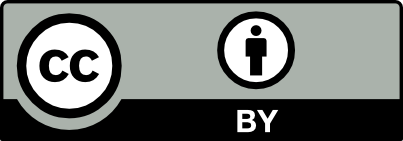


# Watermark

In [ ]:
%load_ext watermark
%watermark -v -m -iv